In [1]:
import sqlite3
import random
import pandas as pd

# Connect to your SQLite database
conn = sqlite3.connect('department.db')
cur = conn.cursor()

# 1. Create the Enrollments table if it doesn't exist
cur.execute('''
CREATE TABLE IF NOT EXISTS Enrollments (
    enrollment_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id INTEGER,
    program_id INTEGER,
    term_id INTEGER,
    enrollment_status TEXT,
    credits_registered INTEGER,
    FOREIGN KEY(student_id) REFERENCES Students(student_id),
    FOREIGN KEY(program_id) REFERENCES Programs(program_id),
    FOREIGN KEY(term_id) REFERENCES Terms(term_id)
)
''')
conn.commit()
print("Enrollments table created successfully.")

# 2. Load students data from the Students table for use in simulation
# (We only need student_id and Financial_Aid)
students_df = pd.read_sql_query("SELECT student_id, Financial_Aid FROM Students", conn)
# Convert to a list of tuples: (student_id, Financial_Aid)
student_list = list(students_df.itertuples(index=False, name=None))

# 3. Set up parameters for enrollment generation
num_terms = 10            # 10 terms (5 years * 2 terms per year)
base_enrollments = 500    # starting number of enrollments for term 1
decline_rate = 0.05       # each successive term has 5% fewer enrollments (approx.)

# We'll store enrollment records as tuples
enrollments = []

# For each term (term_id assumed to be 1-indexed and in chronological order)
for term_index in range(num_terms):
    term_id = term_index + 1
    # Calculate number of enrollments for this term (simulate slight decline over time)
    num_enrollments = int(base_enrollments * (1 - decline_rate * term_index))
    
    for _ in range(num_enrollments):
        # Choose a random student from the list
        student = random.choice(student_list)
        student_id, financial_aid = student
        
        # Define weights for program selection based on term and student financial aid:
        # Engineering (Programs 1 and 2): weight increases over time
        eng_weight = 1 + 0.1 * term_index
        
        # Business (Programs 3 and 4): base weight 1, but if the student receives financial aid, boost weight
        bus_weight = 1.5 if financial_aid == "True" else 1.0
        
        # Arts & Sciences (Programs 5 and 6): weight decreases over time (but not below 0.1)
        arts_weight = max(1 - 0.1 * term_index, 0.1)
        
        # Build a dictionary mapping program IDs to weights
        weights = {
            1: eng_weight,  # Computer Science (Engineering)
            2: eng_weight,  # Mechanical Engineering (Engineering)
            3: bus_weight,  # Finance (Business)
            4: bus_weight,  # Marketing (Business)
            5: arts_weight, # History (Arts & Sciences)
            6: arts_weight  # Psychology (Arts & Sciences)
        }
        
        # Randomly choose a program based on the weights
        program_ids = list(weights.keys())
        weight_values = list(weights.values())
        program_id = random.choices(program_ids, weights=weight_values, k=1)[0]
        
        # Set enrollment status and credits registered
        enrollment_status = "Active"
        credits_registered = random.choice([12, 15, 18])
        
        enrollments.append((student_id, program_id, term_id, enrollment_status, credits_registered))

print(f"Generated {len(enrollments)} enrollment records across {num_terms} terms.")

# 4. Insert the generated enrollment data into the Enrollments table
cur.executemany('''
INSERT INTO Enrollments (student_id, program_id, term_id, enrollment_status, credits_registered)
VALUES (?, ?, ?, ?, ?)
''', enrollments)
conn.commit()

print("Enrollment data inserted successfully.")

# Optional: Verify the first few records
cur.execute('SELECT * FROM Enrollments LIMIT 5')
for row in cur.fetchall():
    print(row)

conn.close()


Enrollments table created successfully.
Generated 3874 enrollment records across 10 terms.
Enrollment data inserted successfully.
(1, 96, 4, 1, 'Active', 15)
(2, 398, 1, 1, 'Active', 15)
(3, 189, 2, 1, 'Active', 15)
(4, 327, 4, 1, 'Active', 12)
(5, 224, 6, 1, 'Active', 12)


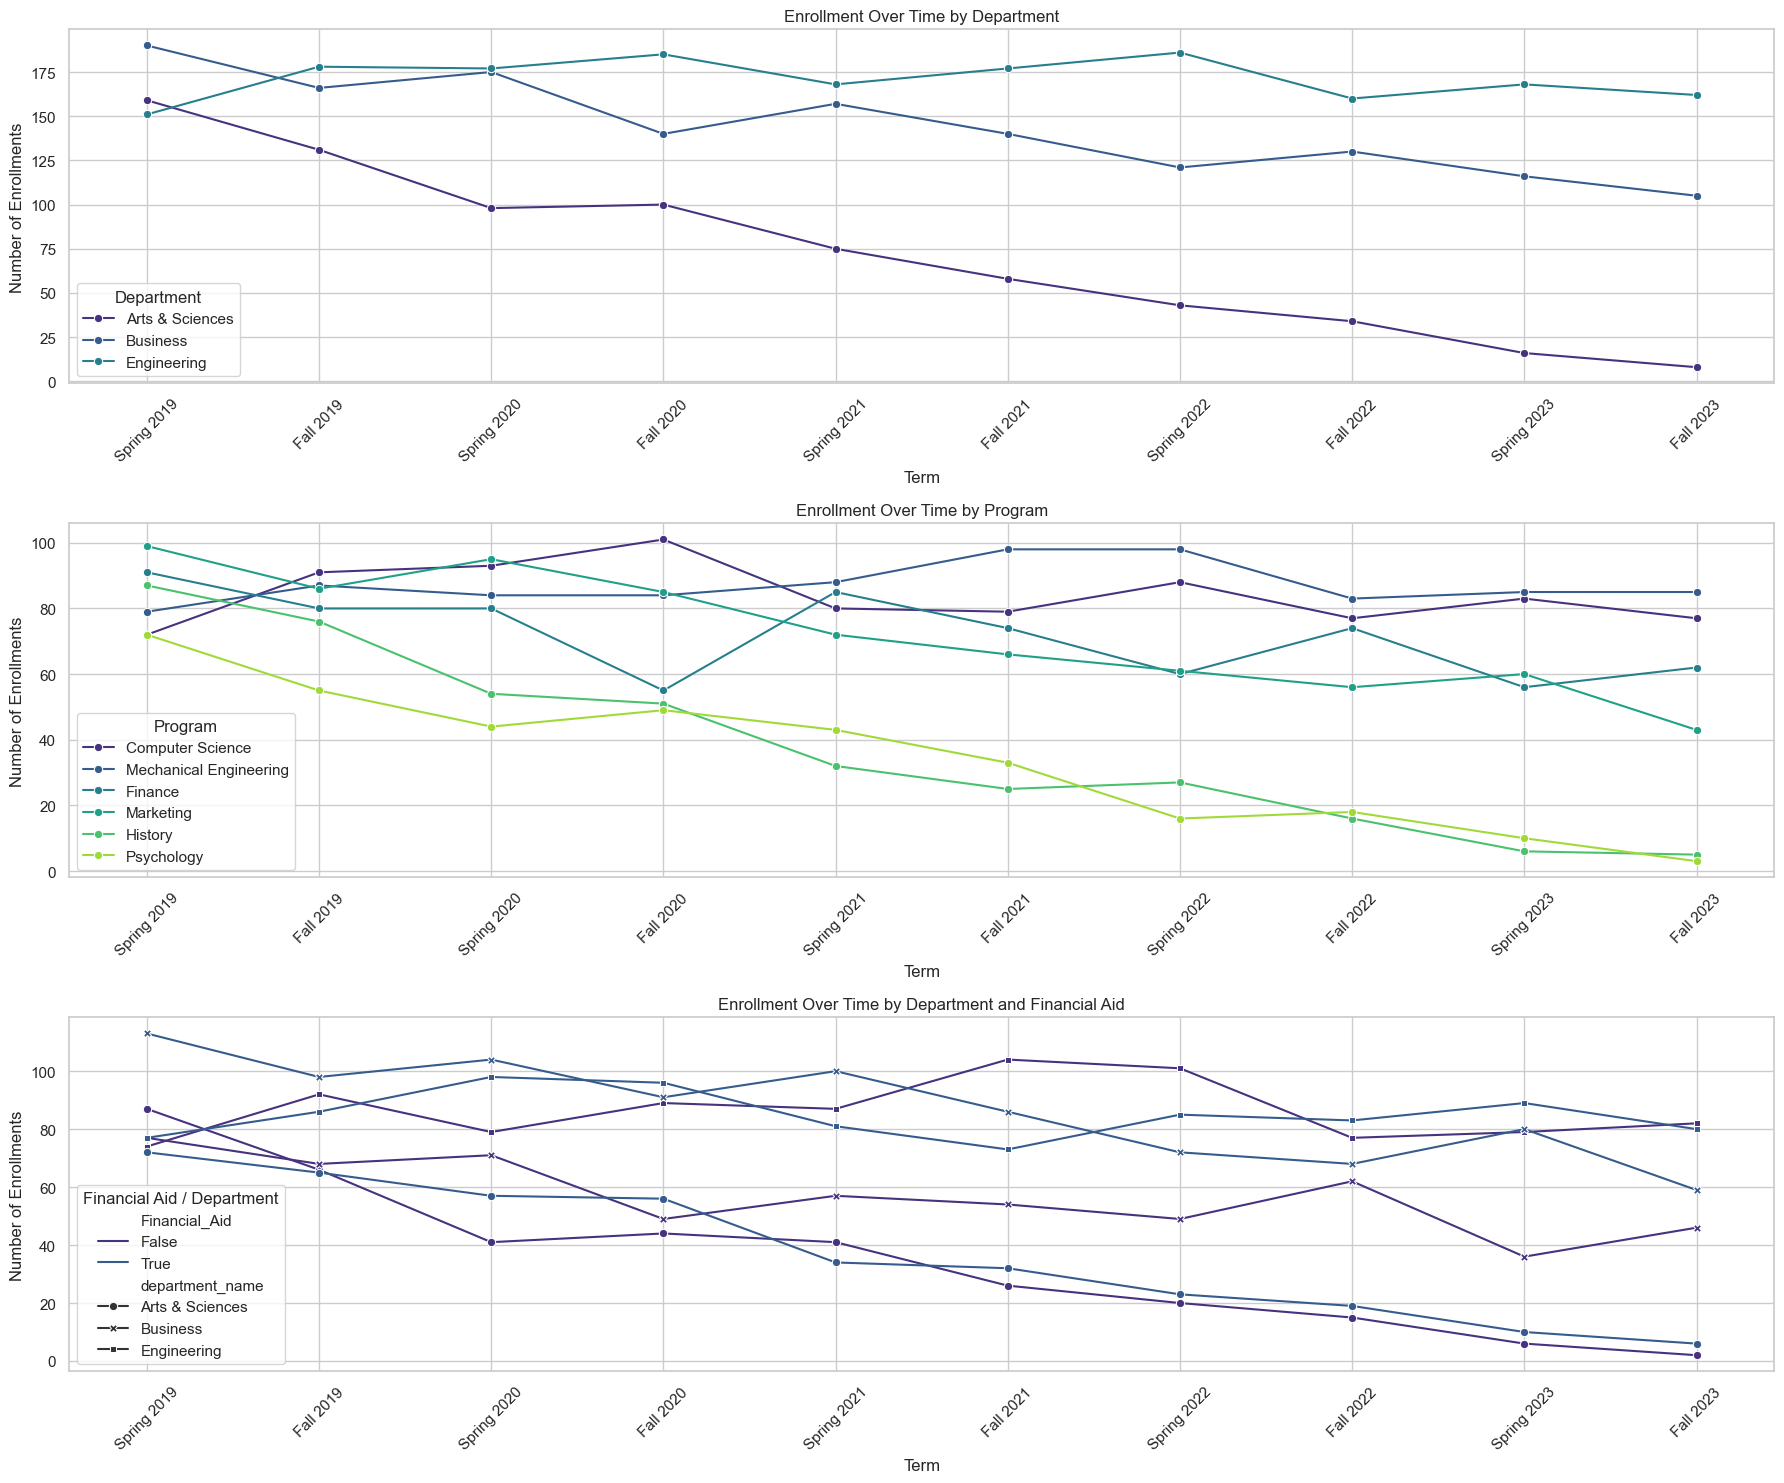

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the database
conn = sqlite3.connect('department.db')

# Query 1: Enrollment over time and by department
query_dept = """
SELECT T.term_name, D.department_name, COUNT(E.enrollment_id) AS enrollments
FROM Enrollments E
JOIN Terms T ON E.term_id = T.term_id
JOIN Programs P ON E.program_id = P.program_id
JOIN Departments D ON P.department_id = D.department_id
GROUP BY T.term_name, D.department_name
ORDER BY T.term_id, D.department_name;
"""
df_dept = pd.read_sql_query(query_dept, conn)

# Query 2: Enrollment over time and by program
query_prog = """
SELECT T.term_name, P.program_name, COUNT(E.enrollment_id) AS enrollments
FROM Enrollments E
JOIN Terms T ON E.term_id = T.term_id
JOIN Programs P ON E.program_id = P.program_id
GROUP BY T.term_name, P.program_name
ORDER BY T.term_id, P.program_id;
"""
df_prog = pd.read_sql_query(query_prog, conn)

# Query 3: Enrollment over time by department and financial aid
query_dept_fa = """
SELECT T.term_name, D.department_name, S.Financial_Aid, COUNT(E.enrollment_id) AS enrollments
FROM Enrollments E
JOIN Terms T ON E.term_id = T.term_id
JOIN Programs P ON E.program_id = P.program_id
JOIN Departments D ON P.department_id = D.department_id
JOIN Students S ON E.student_id = S.student_id
GROUP BY T.term_name, D.department_name, S.Financial_Aid
ORDER BY T.term_id, D.department_name, S.Financial_Aid;
"""
df_dept_fa = pd.read_sql_query(query_dept_fa, conn)

conn.close()

# Optional: If term names are strings like "Fall 2019", "Spring 2020", 
# and you want to preserve their chronological order, you might create an ordered list:
ordered_terms = df_dept['term_name'].unique()

sns.set(style="whitegrid", palette="viridis")
plt.figure(figsize=(18, 15))

# Plot 1: Enrollment over time by department
plt.subplot(3, 1, 1)
sns.lineplot(data=df_dept, x='term_name', y='enrollments', hue='department_name', marker="o")
plt.title("Enrollment Over Time by Department")
plt.xlabel("Term")
plt.ylabel("Number of Enrollments")
plt.xticks(rotation=45)
plt.legend(title="Department")

# Plot 2: Enrollment over time by program
plt.subplot(3, 1, 2)
sns.lineplot(data=df_prog, x='term_name', y='enrollments', hue='program_name', marker="o")
plt.title("Enrollment Over Time by Program")
plt.xlabel("Term")
plt.ylabel("Number of Enrollments")
plt.xticks(rotation=45)
plt.legend(title="Program")

# Plot 3: Enrollment over time by department and financial aid
plt.subplot(3, 1, 3)
# Here we combine department and financial aid by plotting with hue = Financial_Aid 
# and style = department_name so that you can see both dimensions.
sns.lineplot(data=df_dept_fa, x='term_name', y='enrollments',
             hue='Financial_Aid', style='department_name', markers=True, dashes=False)
plt.title("Enrollment Over Time by Department and Financial Aid")
plt.xlabel("Term")
plt.ylabel("Number of Enrollments")
plt.xticks(rotation=45)
plt.legend(title="Financial Aid / Department")

plt.tight_layout()
plt.show()
